## To do list:

## Model instability has been fixed (the unique depths needed to be sorted)

## Possible ways to improve model performance

* Add atmospheric CO2
* Apply your better spike removal code to the other sites
* Try the interpolated precip from PRISM
* Try random forest model
* Interpolate missing CO2 and soil moisture (try single site interpolation)
* Try neural net model
* Use latitude instead of site number
* Add elevation
* Add land cover type (maybe we should try biomass carbon density maps instead)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# sites is a list of locations (e.g., "Calhoun"),
# all_pits is a dict with sites as keys, and lists of pits 
# at each site as the values
all_pits = {}
sites = os.listdir('../../processed_data')

# Loop through all sites to construct dict of sites/pits
for site in sites:
    cur_pits = []
    for pro_file in os.listdir(os.path.join('../../processed_data/', site)):
        cur_pits.append(pro_file.split('_')[0])
        
    all_pits[site] = cur_pits

# Data will be a dict with pits as keys, np arrays as values
data = {}
# This is a list of all the features for R1C1. We'll want to make this an exhaustive 
# list of all potential features across all pits
features = ['CO2', 'timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 
            'WaterPotential', 'ReductionPotential', 'Pit', 'Depth', 'Site', 'Season']
m = len(features)

# Define site and pit number indices
site_nos = {'Calhoun': 0, 'Shale_Hills': 2, 
            'Catalina-Jemez': 1, 'Seca_Floresta': 3}
pit_nos = {}
i = 0
for site, pits in all_pits.items():
    for pit in pits:
        pit_nos[pit] = i
        i += 1
        
# Remove pits with manual samples
del all_pits['Seca_Floresta']
all_pits['Calhoun'].remove('R1C2')
all_pits['Shale_Hills'].remove('SPMS')

In [2]:
total_count = 0
for site in all_pits.keys():
    for pit in all_pits[site]:
        infile=os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
        with open(infile) as f:
            for i, l in enumerate(f):
                pass
        nlines = i + 1
        total_count += nlines
        print(site, pit, '--', nlines)
print(total_count)

Calhoun R1C1 -- 28388
Calhoun R1H1 -- 28394
Calhoun R1P1 -- 28393
Catalina-Jemez BGZOB1 -- 27277
Catalina-Jemez BGZOB2 -- 27302
Catalina-Jemez BGZOB3 -- 27297
Catalina-Jemez BGZOB4 -- 27275
Catalina-Jemez Green1 -- 27976
Catalina-Jemez Green2 -- 6995
Catalina-Jemez Green3 -- 27975
Catalina-Jemez MC1 -- 72374
Catalina-Jemez MC2 -- 72658
Catalina-Jemez MC3 -- 72539
Catalina-Jemez MC4 -- 72540
Catalina-Jemez MC5 -- 71698
Catalina-Jemez MC6 -- 72539
Shale_Hills LRMS -- 14137
Shale_Hills NPMS -- 34448
Shale_Hills SPVF -- 2999
Shale_Hills TMMS -- 35403
778607


In [3]:
# Load in and merge all files
for site in all_pits.keys():
    for pit in all_pits[site]:
        infile=os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
        df = pd.read_csv(infile, parse_dates=[0], na_values=[-99999])

        # Remove records without any CO2 data
        co2_cols = [col for col in df.columns if 'CO2' in col]
        df = df[~df.loc[:, co2_cols].isna().all(axis=1)]
        
        depths = []
        for col in df.columns:
            if ('precip' not in col) and ('DateTime' not in col):
                depths.append(col.split('_')[1].split('cm')[0])
        unique_depths = list(set(depths))
        unique_depths.sort()

        # t is the number of time steps
        t = df.shape[0]

        # data shape is the # of observations (# time points * depths), # features
        cur_data = np.empty((t*len(unique_depths), m))
        cur_data[:] = np.nan

        for i, depth in enumerate(unique_depths):
            depth_cols = [col for col in df.columns if '_%scm' % depth in col]
            for j, feature in enumerate(features):
                # Look for columns with this feature and depth in the name
                if feature == 'precip':
                    col = 'PRISM_precip.mm'
                elif feature == 'timestamp':
                    col = [col for col in df.columns if 'DateTime' in col]
                    col = col[0]
                elif feature == 'Season':
                    col = [col for col in df.columns if 'DateTime' in col]
                    df['quarter'] = df[col[0]].dt.quarter
                    col = 'quarter'
                else:
                    matches = [col for col in depth_cols if feature in col]

                    # Correct for fact that "O2" search returns "CO2" as well
                    if feature == 'O2':
                        matches = [col for col in matches if 'CO2' not in col]

                    if len(matches) > 1:
                        raise ValueError("""More than one possible match found for 
                        %s %s %scm %s""" %(site, pit, depth, feature))
                    elif len(matches) == 1:
                        col = matches[0]
                    else:
                        col = ""
                        continue
    
                # Now that we have the column name, add this subset to cur_data
                cur_data[i*t:(i+1)*t, j] = df[col].values

            # Add in depth
            cur_data[i*t:(i+1)*t, features.index('Depth')] = depth
        
        # Add in pit and site indices
        cur_data[:, features.index('Pit')] = pit_nos[pit]
        cur_data[:, features.index('Site')] = site_nos[site]
        
        # Copy current data to dict of all data
        data[pit] = cur_data.copy()

In [4]:
# Merge all data into a single numpy array
for i, (pit, array) in enumerate(data.items()):
    if i == 0:
        merged = array.copy()
    else:
        merged = np.append(merged, array, axis=0)

# Remove rows without any CO2 data
all_rows, _ = merged.shape
merged = merged[~np.isnan(merged[:, 0]), :]
trimmed = all_rows - merged.shape[0]
print(f'Removed {trimmed:,} rows without CO2 data')

df = pd.DataFrame(data=merged, columns=features)

Removed 115,759 rows without CO2 data


In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [6]:
#For the nearest neighbors model, run this cell and all subsequent cells

df.drop(columns=['WaterPotential', 'ReductionPotential'], 
        inplace=True)

df.dropna(inplace=True)
#df.reset_index(drop=True, inplace=True)
df

,CO2,timestamp,precip,SoilMoisture,BulkEC,Temp,O2,Pit,Depth,Site,Season
6794,13570.0000,1.459382e+18,0.0,0.358000,0.044000,16.705000,19.413019,0.0,50.0,0.0,1.0
6795,13830.0000,1.459386e+18,0.0,0.358000,0.044000,16.770000,19.417373,0.0,50.0,0.0,1.0
6796,14100.0000,1.459390e+18,0.0,0.358000,0.044000,16.835000,19.421726,0.0,50.0,0.0,1.0
6797,14315.0000,1.459393e+18,0.0,0.358000,0.044000,16.890000,19.425410,0.0,50.0,0.0,1.0
6798,14515.0000,1.459397e+18,0.0,0.358000,0.044000,16.940000,19.428758,0.0,50.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1357397,17283.8575,1.378375e+18,0.0,0.206000,0.118333,14.052648,12.242505,16.0,60.0,1.0,3.0
1357398,17157.5350,1.378379e+18,0.0,0.205333,0.116667,14.057570,12.195345,16.0,60.0,1.0,3.0
1357399,17048.8825,1.378382e+18,0.0,0.205500,0.115000,14.036808,12.112427,16.0,60.0,1.0,3.0
1357400,16947.1550,1.378386e+18,0.0,0.201400,0.116667,14.015850,11.981998,16.0,60.0,1.0,3.0


In [41]:
#Model Comparison code starts below. Only cells 1-7 (except 5) need to be run in order to start the model comparison section.

df[(df.Pit==2) & (df.Depth==50)]

,CO2,timestamp,precip,SoilMoisture,BulkEC,Temp,O2,Pit,Depth,Site,Season
34494,23385.0,1.459382e+18,0.0,0.3180,0.0280,16.125,19.027963,2.0,50.0,0.0,1.0
34495,23910.0,1.459386e+18,0.0,0.3180,0.0280,16.090,18.875730,2.0,50.0,0.0,1.0
34496,24175.0,1.459390e+18,0.0,0.3185,0.0275,16.080,18.775857,2.0,50.0,0.0,1.0
34497,24395.0,1.459393e+18,0.0,0.3190,0.0280,16.055,18.774234,2.0,50.0,0.0,1.0
34498,24730.0,1.459397e+18,0.0,0.3190,0.0280,16.030,18.772611,2.0,50.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
45172,14290.0,1.501186e+18,0.0,0.2040,0.0160,24.975,19.405563,2.0,50.0,0.0,3.0
45173,14220.0,1.501189e+18,0.0,0.2040,0.0160,25.005,19.355239,2.0,50.0,0.0,3.0
45174,14145.0,1.501193e+18,0.0,0.2040,0.0160,25.010,19.355563,2.0,50.0,0.0,3.0
45175,14210.0,1.501196e+18,0.0,0.2040,0.0160,25.010,19.355563,2.0,50.0,0.0,3.0


11292.353744415708


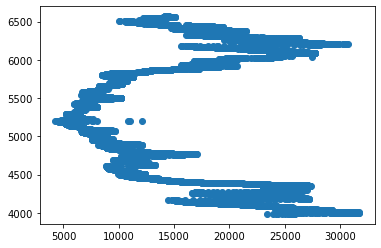

In [42]:
#Run this for systematically missing values
from sklearn import metrics

df_nan=df.copy(deep=True)
df_nan.CO2.loc[(df.Pit==2) & (df.Depth==50)]=np.nan

#df_nan.SoilMoisture.loc[df_nan.sample(frac=0.5).index] = np.nan



nan_index=df_nan[df_nan.CO2.notna()==False]
not_nan_index=df_nan[df_nan.CO2.notna()==True]


df_nan_linear=df_nan.copy(deep=True)
df_nan_median=df_nan.copy(deep=True)

df_nan_median.CO2=df_nan_median.CO2.fillna(np.nanmedian(df_nan_median.CO2))


df_nan_linear.CO2=df_nan_linear.CO2.interpolate()

#df_nan_linear.CO2=df_nan_linear.CO2.fillna(np.nanmedian(df_nan_linear.CO2))


print(metrics.mean_squared_error(df_nan_linear.CO2.loc[nan_index.index], df.CO2.loc[nan_index.index], squared=False))
plt.scatter(df.CO2.loc[nan_index.index], df_nan_linear.CO2.loc[nan_index.index])


In [68]:
#This is a fairly shallow neural network that gives the best RMSE for this missing site and depth

df_st =  StandardScaler().fit_transform(df_nan.loc[not_nan_index.index]) 
df_st1=pd.DataFrame(data=df_st)
#df_st1.index=not_nan_index.index
#df_st1=df_st1.dropna()
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

#df_st1.columns= ['CO2','timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'Pit', 'Depth', 'Site', 'Season']
#X=df_st1[[ 'precip', 'CO2', 'BulkEC', 'Temp', 'O2', 'Depth']]  # Features\n",

df_st1.columns= ['CO2','timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'Pit', 'Depth', 'Site', 'Season']
X=df_st1[[ 'timestamp','precip','SoilMoisture','BulkEC','Temp','O2','Pit','Depth']]
y=df_st1['CO2']  # Labels\n",


from tensorflow import random
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

X_reshape = np.reshape(X.values, (X.values.shape[0], X.values.shape[1], 1))
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
regressor=Sequential([Dense(units=18,input_shape = (X.values.shape[1], ), activation='tanh'), 
                       Dense(units=1, activation='tanh')])
#regressor = Sequential()

#regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (Xtrain_reshape.shape[1], 1), recurrent_dropout=.1))


opt=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=.9)


regressor.compile(optimizer = opt, loss = 'mean_squared_error')

regressor.fit(X.values, y.values, epochs = 50, batch_size = 400,validation_data=(X.loc[nan_index.index].values, y.loc[nan_index.index].values))

Epoch 1/100
2068/2068 [==============================] - 1s 573us/step - loss: 0.6446 - val_loss: 0.3453
Epoch 2/100
2068/2068 [==============================] - 1s 533us/step - loss: 0.4969 - val_loss: 0.2936
Epoch 3/100
2068/2068 [==============================] - 1s 526us/step - loss: 0.4620 - val_loss: 0.2670
Epoch 4/100
2068/2068 [==============================] - 1s 524us/step - loss: 0.4473 - val_loss: 0.2725
Epoch 5/100
2068/2068 [==============================] - 1s 519us/step - loss: 0.4403 - val_loss: 0.2581
Epoch 6/100
2068/2068 [==============================] - 1s 519us/step - loss: 0.4347 - val_loss: 0.2426
Epoch 7/100
2068/2068 [==============================] - 1s 527us/step - loss: 0.4305 - val_loss: 0.2307
Epoch 8/100
2068/2068 [==============================] - 1s 525us/step - loss: 0.4269 - val_loss: 0.2334
Epoch 9/100
2068/2068 [==============================] - 1s 532us/step - loss: 0.4236 - val_loss: 0.2284
Epoch 10/100
2068/2068 [==============================]

2068/2068 [==============================] - 1s 524us/step - loss: 0.4054 - val_loss: 0.2263
Epoch 79/100
2068/2068 [==============================] - 1s 518us/step - loss: 0.4054 - val_loss: 0.2254
Epoch 80/100
2068/2068 [==============================] - 1s 530us/step - loss: 0.4053 - val_loss: 0.2227
Epoch 81/100
2068/2068 [==============================] - 1s 518us/step - loss: 0.4053 - val_loss: 0.2235
Epoch 82/100
2068/2068 [==============================] - 1s 520us/step - loss: 0.4053 - val_loss: 0.2275
Epoch 83/100
2068/2068 [==============================] - 1s 526us/step - loss: 0.4053 - val_loss: 0.2258
Epoch 84/100
2068/2068 [==============================] - 1s 525us/step - loss: 0.4052 - val_loss: 0.2284
Epoch 85/100
2068/2068 [==============================] - 1s 532us/step - loss: 0.4052 - val_loss: 0.2270
Epoch 86/100
2068/2068 [==============================] - 1s 515us/step - loss: 0.4052 - val_loss: 0.2220
Epoch 87/100
2068/2068 [==============================] - 1

In [91]:
#This is a denser network that has also acheived good results, although not as good as the shallow network in the cell above
df_st =  StandardScaler().fit_transform(df_nan.loc[not_nan_index.index]) 
df_st1=pd.DataFrame(data=df_st)
#df_st1.index=not_nan_index.index
#df_st1=df_st1.dropna()
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

#df_st1.columns= ['CO2','timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'Pit', 'Depth', 'Site', 'Season']
#X=df_st1[[ 'precip', 'CO2', 'BulkEC', 'Temp', 'O2', 'Depth']]  # Features\n",

df_st1.columns= ['CO2','timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'Pit', 'Depth', 'Site', 'Season']
X=df_st1[[ 'timestamp','precip','SoilMoisture','BulkEC','Temp','O2','Pit','Depth']]
y=df_st1['CO2']  # Labels\n",


from tensorflow import random
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

X_reshape = np.reshape(X.values, (X.values.shape[0], X.values.shape[1], 1))
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
regressor=Sequential([Dense(units=400, input_shape = (X.values.shape[1], ), activation='tanh'), Dense(units=200, activation='tanh'),
                      
                      Dense(units=100, activation='tanh'),Dropout(.1),Dense(units=50, activation='tanh'),
                      Dense(units=10, activation='tanh'),Dense(units=5, activation='tanh'),Dense(units=1, activation='tanh')])
#regressor = Sequential()

#regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (Xtrain_reshape.shape[1], 1), recurrent_dropout=.1))


opt=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=.9)


regressor.compile(optimizer = opt, loss = 'mean_squared_error')

regressor.fit(X.values, y.values, epochs = 50, batch_size = 200,validation_data=(X.loc[nan_index.index].values, y.loc[nan_index.index].values))

Epoch 1/30
8270/8270 [==============================] - 16s 2ms/step - loss: 0.3796 - val_loss: 0.1738
Epoch 2/30
8270/8270 [==============================] - 16s 2ms/step - loss: 0.3384 - val_loss: 0.1650
Epoch 3/30
8270/8270 [==============================] - 16s 2ms/step - loss: 0.3324 - val_loss: 0.1635
Epoch 4/30
8270/8270 [==============================] - 16s 2ms/step - loss: 0.3282 - val_loss: 0.1574
Epoch 5/30
8270/8270 [==============================] - 16s 2ms/step - loss: 0.3261 - val_loss: 0.1642
Epoch 6/30
8270/8270 [==============================] - 16s 2ms/step - loss: 0.3244 - val_loss: 0.1575
Epoch 7/30
8270/8270 [==============================] - 15s 2ms/step - loss: 0.3232 - val_loss: 0.1561
Epoch 8/30
8270/8270 [==============================] - 15s 2ms/step - loss: 0.3225 - val_loss: 0.1551
Epoch 9/30
8270/8270 [==============================] - 15s 2ms/step - loss: 0.3216 - val_loss: 0.1568
Epoch 10/30
8270/8270 [==============================] - 15s 2ms/step - l

In [185]:
#This doesn't need to be run. It is used to check if you have a GPU that can be used to run the code instead of a CPU
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


9

In [92]:
st_nan=  StandardScaler().fit_transform(df_nan.loc[nan_index.index])
df_st_nan=pd.DataFrame(data=st_nan)

df_st_nan.index=nan_index.index


df_st_nan.columns= ['CO2','timestamp', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'Pit', 'Depth', 'Site', 'Season']
X_nan=df_st_nan[[ 'timestamp','precip','SoilMoisture','BulkEC','Temp','O2','Pit','Depth']]
y_nan=df_st_nan['CO2']  # Labels\n",

Xnan=X_nan.values
Xnan_reshape = np.reshape(Xnan, (Xnan.shape[0], Xnan.shape[1], 1))

regressor_prediction=regressor.predict(Xnan)
regressor_prediction_original=regressor_prediction*np.std(df_nan['CO2'].loc[not_nan_index.index])+np.mean(df_nan.CO2.loc[not_nan_index.index])
#regressor.summary()

C:\Users\marcb\anaconda3\lib\site-packages\sklearn\utils\extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\marcb\anaconda3\lib\site-packages\sklearn\utils\extmath.py:711: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


In [93]:
#Max_iter=200
    #hidden_layer_size=400: RMSE=4307
    #hidden_layer_size=100: RMSE=5016
    #hidden_layer_size=1000: RMSE=4020
#Max_iter=2000
    #hidden_layer_size=400: RMSE=4307
    #hidden_layer_size=100: RMSE=5016
    #hidden_layer_size=1000: RMSE=3890
#Max_iter=2000
    #hidden_layer_size=2000:  
        #batch_size=2000: RMSE=3731
a=df.CO2.loc[nan_index.index]
#b=CO2_predict_original
#c=CO2_neural_predict_original
d=df_nan_linear.CO2.loc[nan_index.index]
e=df_nan_median.CO2.loc[nan_index.index]
f=regressor_prediction_original

#print('kNN without lag RMSE:',metrics.mean_squared_error(a, b, squared=False))
#print('Neural RMSE:',metrics.mean_squared_error(a, c, squared=False))
print('Linear RMSE:', metrics.mean_squared_error(a, d, squared=False))
print('Median RMSE:', metrics.mean_squared_error(a, e, squared=False))
print('Keras RMSE:', metrics.mean_squared_error(a, f, squared=False))



#print(metrics.mean_absolute_error(a, b))
#print(metrics.mean_absolute_error(a, c))
print(metrics.mean_absolute_error(a, d))
print(metrics.mean_absolute_error(a, e))
print(metrics.mean_absolute_error(a, f))




print(np.var(df.SoilMoisture))





Linear RMSE: 11292.353744415708
Median RMSE: 12910.899291165331
Keras RMSE: 12126.597474106546
8927.344064205172
10940.212181117353
10397.24180661553
0.007892823381031392


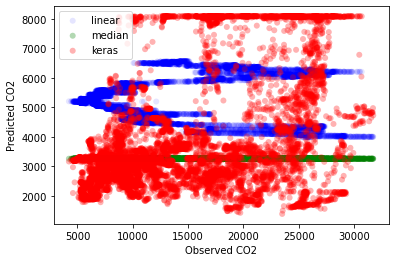

In [94]:
#print(metrics.mean_squared_error(ab, bc, squared=False))
#plt.scatter(a, b)


fig, ax = plt.subplots()

#ax.scatter(a, b, c='r', label='kNN',
 #              alpha=0.1, edgecolors='none')

#ax.scatter(a, c, c='y', label='Neural',
 #              alpha=0.1, edgecolors='none')

ax.scatter(a, d, c='b', label='linear',
               alpha=0.1, edgecolors='none')

ax.scatter(a, e, c='g', label='median',
               alpha=0.3, edgecolors='none')
ax.scatter(a, f, c='r', label='keras',
               alpha=0.3, edgecolors='none')
ax.legend(loc=2)
ax.set_xlabel('Observed CO2')
ax.set_ylabel('Predicted CO2')
plt.show()


In [143]:
import hydroeval as he


print( he.evaluator(he.nse, a, d))
print( he.evaluator(he.nse, a, e))
print( he.evaluator(he.nse, a, f))




[-145.39364866]
[-2.28465701e+31]
[-0.70707141]


In [144]:
from sklearn.metrics import r2_score
print (r2_score(a, d))
print (r2_score(a, e))
print (r2_score(a, f))



-0.2467129700964279
-0.19623469679396233
-0.8087172950652861


In [106]:
len(nan_index)/len(df)

0.03137791044776119

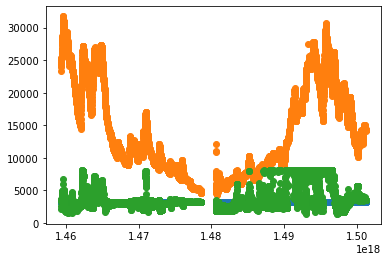

In [95]:
plt.scatter(nan_index.timestamp,e)
plt.scatter(nan_index.timestamp,a)
plt.scatter(nan_index.timestamp,f)


In [ ]:
df_nan